In [28]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Riceleaf",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1754 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
class_names

['BrownSpot', 'Healthy', 'LeafBlast']

In [31]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 2 0 0 0 1 0 0 2 2 0 0 0 2 0 1 0 2 2 2 2 2 2 0 1 2 1 1 2 2 0]


In [1]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

NameError: name 'plt' is not defined

In [33]:
len(dataset)

55

In [34]:
train_size = 0.8
len(dataset)*train_size

44.0

In [35]:
train_ds = dataset.take(40)
len(train_ds)

40

In [36]:
test_ds = dataset.skip(40)
len(test_ds)

15

In [37]:
val_size=0.1
len(dataset)*val_size

5.5

In [38]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [39]:
test_ds = test_ds.skip(5)
len(test_ds)

10

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

44

In [42]:
len(val_ds)

5

In [43]:
len(test_ds)

6

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
#Model Building

In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [48]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
44/44 [==============================] - 215s 4s/step - loss: 1.0668 - accuracy: 0.3802 - val_loss: 0.9884 - val_accuracy: 0.4750
Epoch 2/100
44/44 [==============================] - 107s 2s/step - loss: 0.9657 - accuracy: 0.4971 - val_loss: 0.9296 - val_accuracy: 0.5250
Epoch 3/100
44/44 [==============================] - 96s 2s/step - loss: 0.9098 - accuracy: 0.5421 - val_loss: 0.8264 - val_accuracy: 0.5813
Epoch 4/100
44/44 [==============================] - 96s 2s/step - loss: 0.8889 - accuracy: 0.5307 - val_loss: 0.8423 - val_accuracy: 0.5625
Epoch 5/100
44/44 [==============================] - 100s 2s/step - loss: 0.8901 - accuracy: 0.5499 - val_loss: 0.8815 - val_accuracy: 0.5688
Epoch 6/100
44/44 [==============================] - 88s 2s/step - loss: 0.8869 - accuracy: 0.5207 - val_loss: 0.8510 - val_accuracy: 0.5437
Epoch 7/100
44/44 [==============================] - 97s 2s/step - loss: 0.8608 - accuracy: 0.5321 - val_loss: 0.8219 - val_accuracy: 0.5625
Epoch 8/10

In [53]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 30s 407ms/step - loss: 0.3392 - accuracy: 0.9010


In [54]:
scores

[0.33924031257629395, 0.9010416865348816]

In [55]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 44}

In [57]:
type(history.history['loss'])

list

In [58]:
len(history.history['loss'])

100

In [59]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0668103694915771,
 0.9657431840896606,
 0.9098140597343445,
 0.8888632655143738,
 0.8901454210281372]

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

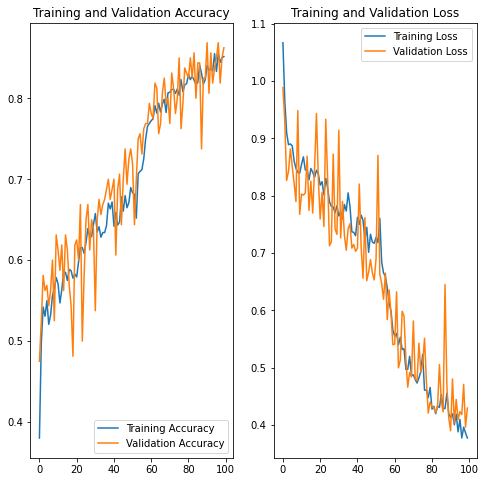

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: LeafBlast
1/1 [==============================] - 1s 573ms/step
predicted label: LeafBlast


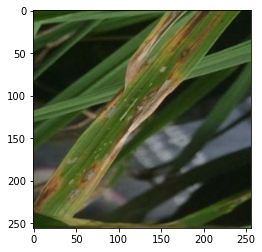

In [62]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [72]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 48ms/step


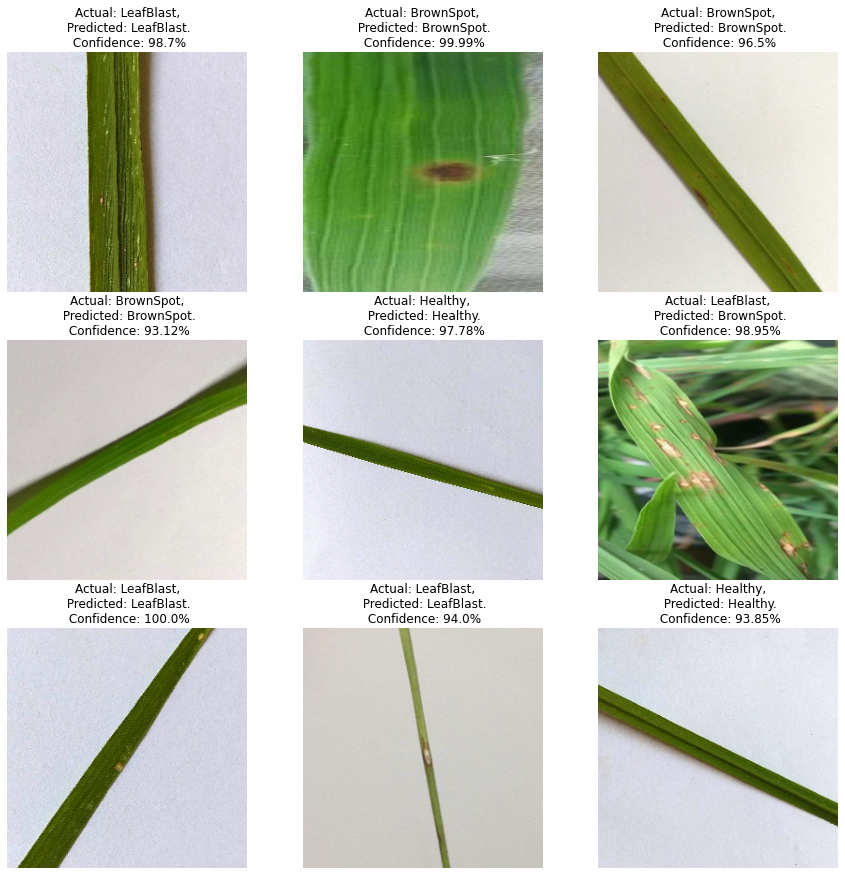

In [73]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [88]:
model_version=1
model.save(f"C:/Users/ADMIN/Downloads/models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/ADMIN/Downloads/models/1\assets


INFO:tensorflow:Assets written to: C:/Users/ADMIN/Downloads/models/1\assets
